## Dataset download

In [1]:
%matplotlib inline
import os
import urllib.request
import pickle
import tarfile
import ntpath

if not os.path.exists('data'):
    os.makedirs('data')
if not os.path.exists(os.path.join('data','cifar-10-python.tar.gz')):
    urllib.request.urlretrieve('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz', os.path.join('data','cifar-10-python.tar.gz'))

## Reading from the archive

In [2]:
batch_filenames = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
test_filename = 'test_batch'
    
batches = []
test_batch = None

with tarfile.open(os.path.join('data','cifar-10-python.tar.gz'), 'r:gz') as tar_file:
    for file_info in tar_file.getmembers():
        file = tar_file.extractfile(file_info)
        if file is not None:
            if ntpath.basename(file_info.name) in batch_filenames:
                batch = pickle.load(file, encoding='bytes')
                batches.append(batch)
            if ntpath.basename(file_info.name) == test_filename:
                test_batch = pickle.load(file, encoding='bytes')

print(test_batch[b'data'].shape)
print(len(test_batch[b'filenames']))
print(len(test_batch[b'labels']))
print(test_batch[b'batch_label'])


(10000, 3072)
10000
10000
b'testing batch 1 of 1'


In [3]:
import pandas as pd

test_batch[b'data'] = test_batch[b'data'].tolist()
test_batch[b'batch_label'] = [test_batch[b'batch_label']] * len(test_batch[b'labels'])

df = pd.DataFrame.from_dict(test_batch)
print(df.head())

            b'batch_label'                                            b'data'  \
0  b'testing batch 1 of 1'  [158, 159, 165, 166, 160, 156, 162, 159, 158, ...   
1  b'testing batch 1 of 1'  [235, 231, 232, 232, 232, 232, 232, 232, 232, ...   
2  b'testing batch 1 of 1'  [158, 158, 139, 132, 166, 182, 187, 193, 199, ...   
3  b'testing batch 1 of 1'  [155, 167, 176, 190, 177, 166, 168, 166, 170, ...   
4  b'testing batch 1 of 1'  [65, 70, 48, 30, 23, 40, 44, 45, 45, 40, 10, 1...   

                   b'filenames'  b'labels'  
0  b'domestic_cat_s_000907.png'          3  
1     b'hydrofoil_s_000078.png'          8  
2      b'sea_boat_s_001456.png'          8  
3      b'jetliner_s_001705.png'          0  
4    b'green_frog_s_001658.png'          6  


In [4]:
for batch in batches:
    batch[b'data'] = batch[b'data'].tolist()
    batch[b'batch_label'] = [batch[b'batch_label']] * len(batch[b'labels'])
    df = df.append(pd.DataFrame.from_dict(batch), ignore_index=True)

In [5]:
df['is_test'] = df[b'batch_label'] == b'testing batch 1 of 1' 
print(df.info())
print(df.head())
print(df.tail())
print(df[b'filenames'].is_unique)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 5 columns):
b'batch_label'    60000 non-null object
b'data'           60000 non-null object
b'filenames'      60000 non-null object
b'labels'         60000 non-null int64
is_test           60000 non-null bool
dtypes: bool(1), int64(1), object(3)
memory usage: 1.9+ MB
None
            b'batch_label'                                            b'data'  \
0  b'testing batch 1 of 1'  [158, 159, 165, 166, 160, 156, 162, 159, 158, ...   
1  b'testing batch 1 of 1'  [235, 231, 232, 232, 232, 232, 232, 232, 232, ...   
2  b'testing batch 1 of 1'  [158, 158, 139, 132, 166, 182, 187, 193, 199, ...   
3  b'testing batch 1 of 1'  [155, 167, 176, 190, 177, 166, 168, 166, 170, ...   
4  b'testing batch 1 of 1'  [65, 70, 48, 30, 23, 40, 44, 45, 45, 40, 10, 1...   

                   b'filenames'  b'labels'  is_test  
0  b'domestic_cat_s_000907.png'          3     True  
1     b'hydrofoil_s_000078.png'     

## Reshaping of arrays so they form a valid image

In [6]:
import numpy as np


def reshape_image(row):
    img_array = np.reshape(row[b'data'], (32,32,3), order='F')
    img_array = np.swapaxes(img_array, 0, 1)
    img_array = img_array / 255
    return img_array

if not os.path.exists(os.path.join('data','images')):
    os.makedirs(os.path.join('data','images'))

resized = []

df[b'filenames'] = df[b'filenames'].apply(lambda x: x.decode("utf-8"))
df[b'labels'] = df[b'labels'].apply(lambda x: int(x))

for index, row in df.iterrows():
    img_array = reshape_image(row)
    np.save(os.path.join('data','images',row[b'filenames']+'.npy'),img_array)

index = pd.DataFrame.from_dict({'filename':df[b'filenames'], 
                                  'label':df[b'labels'], 'is_test':df['is_test']})
index.to_csv(os.path.join('data', 'index.csv'))

## Checking if image looks ok

domestic_cat_s_000907.png


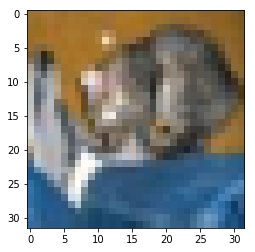

In [9]:
import matplotlib.pyplot as plt

index_loaded = pd.read_csv(os.path.join('data', 'index.csv'))
img = np.load(os.path.join('data','images',index_loaded['filename'].loc[0]+'.npy'))
plt.imshow(img)
print(index_loaded['filename'].loc[0])